In [88]:
import datetime
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import seaborn as sns
from datetime import datetime as dt
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, RFECV
from math import sqrt

%run src/columns.py
%run src/data-cleaning.py
%run src/feature-engineering.py
%run src/modeling.py
%run src/aws-scripts.py

In [89]:
csv_file_names = ('LoanStats3a_securev1.csv', 'LoanStats3b_securev1.csv', 'LoanStats3c_securev1.csv',
                  'LoanStats3d_securev1.csv', 'LoanStats_securev1_2016Q1.csv', 'LoanStats_securev1_2016Q2.csv',
                  'LoanStats_securev1_2016Q3.csv', 'LoanStats_securev1_2016Q4.csv', 'LoanStats_securev1_2017Q1.csv',
                  'LoanStats_securev1_2017Q2.csv', 'LoanStats_securev1_2017Q3.csv', 'LoanStats_securev1_2017Q4.csv',
                  'LoanStats_securev1_2018Q1.csv', 'LoanStats_securev1_2018Q1.csv', 'LoanStats_securev1_2018Q2.csv')

In [91]:
def create_dummy_cols(df):
    #dummies = get_state_dummies(df['addr_state'])
    #df = pd.concat([df, dummies], axis=1)
    #dummies = get_verification_dummies(df['verification_status'])
    #df = pd.concat([df, dummies], axis=1)
    dummies = get_grade_dummies(df['grade'])
    df = pd.concat([df, dummies], axis=1)
    #dummies = get_home_ownership_dummies(df['home_ownership'])
    #df = pd.concat([df, dummies], axis=1)
    #dummies = get_loan_purpose_dummies(df['purpose'])
    #df = pd.concat([df, dummies], axis=1)

    drop_cols = ['grade', 'home_ownership', 'verification_status', 'purpose', 'addr_state']

    for col in drop_cols:
        df.drop(col, axis=1, inplace=True)

    return df

In [90]:
loans = pd.read_pickle('data/raw_dataframe.pkl.bz2')
loans = drop_loan_status(loans)
loans = drop_joint_applicant_loans(loans)
loans = fix_rate_cols(loans)
loans.dropna(subset=['issue_d'], inplace=True)
loans = fix_date_cols(loans)
loans = clean_loan_term_col(loans)
loans = only_include_36_month_loans(loans)
loans = clean_employment_length(loans)
loans = create_missing_data_boolean_columns(loans)
loans = fill_nas(loans, value=-99)
loans = add_issue_date_and_month(loans)
loans = add_supplemental_rate_data(loans)
loans = create_rate_difference_cols(loans)
loans = create_months_since_earliest_cl_col(loans)
loans = create_loan_life_months_col(loans)
loans = change_data_types(loans)
#loans = create_dummy_cols(loans)
loans = drop_unnecessary_cols(loans)

In [92]:
loans = create_dummy_cols(loans)

In [93]:
loans.head(5)

,id,loan_amnt,int_rate,installment,emp_length,annual_inc,issue_d,dti,delinq_2yrs,fico_range_low,...,int_minus_mortgage,int_minus_prime,mths_since_earliest_cr,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G
0,1077501,5000.0,10.650000,162.869995,10.0,24000.0,2011-12-01,27.65,0,735.0,...,6.691999,7.400000,323,0,1,0,0,0,0,0
1,1077175,2400.0,15.960000,84.330002,10.0,12252.0,2011-12-01,8.72,0,735.0,...,12.002000,12.710000,121,0,0,1,0,0,0,0
2,1076863,10000.0,13.490000,339.309998,10.0,49200.0,2011-12-01,20.00,0,690.0,...,9.532000,10.240000,190,0,0,1,0,0,0,0
3,1075269,5000.0,7.900000,156.460007,3.0,36000.0,2011-12-01,11.20,0,730.0,...,3.942000,4.650000,85,1,0,0,0,0,0,0
4,1072053,3000.0,18.639999,109.430000,9.0,48000.0,2011-12-01,5.35,0,660.0,...,14.681999,15.389999,59,0,0,0,0,1,0,0


In [96]:
loans.set_index('id', inplace=True)

In [ ]:
def get_training_and_testing_data(df, split_date='2015-09-01'):
    '''
    Loans before the cutoff date will be used for training the model, the others will be used for
    simulating and evaluating the model's performance.
    '''
    training_loans = df[df['issue_d'].isin(pd.date_range('2010-01-01', split_date)) == True]
    testing_loans = df[df['issue_d'].isin(pd.date_range('2010-01-01', split_date)) == False]
    return training_loans, testing_loans

In [97]:
cutoff_date = '2015-09-01'
training_loans, testing_loans = get_training_and_testing_data(loans, cutoff_date)

In [98]:
len(training_loans)

529507

In [110]:
len(training_loans)

529507

In [99]:
with open('data/loan_rois.pickle', 'rb') as handle:
    loan_rois = pickle.load(handle)
    
len(loan_rois)

529507

In [100]:
training_loans.index = training_loans.index.astype(int)
testing_loans.index = testing_loans.index.astype(int)

In [101]:
roi_col = pd.DataFrame.from_dict(loan_rois, orient='index')
roi_col.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 529507 entries, 1077501 to 36271262
Data columns (total 1 columns):
0    529507 non-null float64
dtypes: float64(1)
memory usage: 8.1 MB


In [102]:
training_loans['roi'] = roi_col
training_loans['roi'].head(10)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


id
1077501    10.289307
1077175    16.248779
1076863    13.707275
1075269     7.783084
1072053    19.114990
1069908    12.606201
1064687   -97.884317
1069866     9.896030
1069057   -30.444461
1069759    16.585693
Name: roi, dtype: float64

In [103]:
sum(training_loans['roi'].isnull())

0

In [104]:
len(training_loans['roi'].isnull())

529507

In [105]:
training_loans['roi'].tail()

id
36221446    17.425537
36330911   -72.777158
36371250    12.703857
36441262    12.677002
36271262    12.943115
Name: roi, dtype: float64

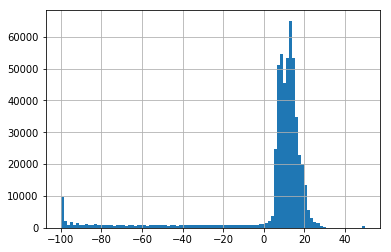

In [106]:
training_loans['roi'].hist(bins=100)

In [87]:
training_loans.to_pickle('data/cleaned_training_loans_.pkl.bz2', compression='bz2')
testing_loans.to_pickle('data/cleaned_testing_loans.pkl.bz2', compression='bz2')

In [109]:
training_loans[['issue_d', 'roi']].groupby(['issue_d'], as_index=False).agg(['mean', 'count'])

roi       
                 mean  count
issue_d                     
2007-06-01 -65.499234      1
2007-07-01 -59.048245     30
2007-08-01 -51.859708     33
2007-09-01 -61.396691     18
2007-10-01 -63.255558     47
2007-11-01 -67.084442     37
2007-12-01 -75.835740     85
2008-01-01 -62.112039    171
2008-02-01 -40.387384    174
2008-03-01 -33.277200    236
2008-04-01 -44.989127    155
2008-05-01 -83.577093     71
2008-06-01 -77.750130     66
2008-07-01 -79.809198     83
2008-08-01 -72.831363     71
2008-09-01 -77.769676     32
2008-10-01 -39.456891     96
2008-11-01 -37.606350    184
2008-12-01 -36.620261    222
2009-01-01 -23.940052    239
2009-02-01 -17.578770    260
2009-03-01   0.168048    276
2009-04-01 -15.155527    289
2009-05-01 -17.457475    319
2009-06-01  -6.858226    354
2009-07-01  -3.029806    373
2009-08-01   1.468989    408
2009-09-01   2.242347    447
2009-10-01   1.228898    544
2009-11-01   0.954226    598
...               ...    ...
2013-04-01   6.178694   7231
2013-05-01   5.829557   7764
2013-06-01   6.017592   8125
2013-07-01   5.664078   8968
2013-08-01   6.147730   9174
2013-09-01   6.430986   9145
2013-10-01   6.592476   9985
2013-11-01   5.788769  10893
2013-12-01   6.048871  11083
2014-01-01   5.570941  11488
2014-02-01   5.254185  10939
2014-03-01   5.239732  11626
2014-04-01   5.026742  13258
2014-05-01   4.508252  13103
2014-06-01   4.400646  11502
2014-07-01   4.523591  19930
2014-08-01   4.397555  13272
2014-09-01   3.263317   7368
2014-10-01   3.111778  26555
2014-11-01   3.449373  16563
2014-12-01   3.356554   6873
2015-01-01   2.936931  23619
2015-02-01   2.839998  16019
2015-03-01   2.047915  16905
2015-04-01   1.979466  23606
2015-05-01   1.921327  21516
2015-06-01   2.036936  19053
2015-07-01   2.241353  30842
2015-08-01   1.808032  23922
2015-09-01   0.676963  18744

[100 rows x 2 columns]